In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [2]:
metadata = pd.DataFrame()
with open("./odi_info.txt") as info_file:
    lines = info_file.readlines()
    lines = [list(map(str,line.strip().split(" - "))) for line in lines]
    metadata = pd.DataFrame([lines[i] for i in range(len(lines))],columns=["date","match_level","match_type","gender","file_name","teams"])
metadata.shape

(2850, 6)

In [3]:
metadata.drop(columns=["match_level","match_type"],inplace=True)

In [4]:
metadata.head()

,date,gender,file_name,teams
0,2024-11-13,male,1456443,Sri Lanka vs New Zealand
1,2024-11-11,male,1457469,Oman vs Netherlands
2,2024-11-10,male,1426551,Australia vs Pakistan
3,2024-11-09,male,1457468,Netherlands vs United Arab Emirates
4,2024-11-08,male,1426550,Australia vs Pakistan


## Player Performance

In [10]:
s = set()
for i in metadata["teams"]:
    x,y = map(str,i.split(" vs "))
    s.add(x)
    s.add(y)
print(s)

{'Zimbabwe', 'United States of America', 'Bermuda', 'England', 'Thailand', 'Ireland', 'Scotland', 'Asia XI', 'Canada', 'Africa XI', 'Australia', 'Papua New Guinea', 'Kenya', 'Oman', 'Bangladesh', 'New Zealand', 'India', 'Jersey', 'United Arab Emirates', 'West Indies', 'Pakistan', 'Nepal', 'South Africa', 'Sri Lanka', 'Hong Kong', 'ICC World XI', 'Netherlands', 'Namibia'}


In [66]:
Indian_matches = metadata[metadata["teams"].str.contains("India")]
Indian_match_dates,Indian_match_files = Indian_matches["date"],Indian_matches["file_name"]

Indian_match_dates = Indian_match_dates.to_numpy()
Indian_match_files = Indian_match_files.to_numpy()

In [220]:

def get_player_df(player_name):
    def player_data_extractor(file_name):
        global player_name

        with open("odis_csv/"+str(file_name)+".csv") as match_file:
            ans = [i.strip() for i in match_file.readlines() if player_name in i]
            return ans[0] if ans!=[] else ""
        
    player_df = pd.DataFrame(columns=["date","player_name","runs","balls","fours","sixes","strike_rate","wickets_taken","runs_conceded","balls_bowled","economy_rate","catches","stumpings","runouts","fantasy_points","out_by"])

    for i in range(len(Indian_match_dates)):
        player_performance = player_data_extractor(Indian_match_files[i])
        if  player_performance != "":
            player_df.loc[i] = [Indian_match_dates[i]]+player_performance.split(",")

    player_df["date"] = pd.to_datetime(player_df["date"])
    player_df["runs"] = player_df["runs"].astype(int)
    player_df["balls"] = player_df["balls"].astype(int)
    player_df["fours"] = player_df["fours"].astype(int)
    player_df["sixes"] = player_df["sixes"].astype(int)
    player_df["strike_rate"] = player_df["strike_rate"].astype(float)
    player_df["wickets_taken"] = player_df["wickets_taken"].astype(int)
    player_df["runs_conceded"] = player_df["runs_conceded"].astype(int)
    player_df["balls_bowled"] = player_df["balls_bowled"].astype(int)
    player_df["economy_rate"] = player_df["economy_rate"].astype(float)
    player_df["catches"] = player_df["catches"].astype(int)
    player_df["stumpings"] = player_df["stumpings"].astype(int)
    player_df["runouts"] = player_df["runouts"].astype(int)
    player_df["fantasy_points"] = player_df["fantasy_points"].astype(float)
    player_df.set_index('date', inplace=True)
    
    return player_df

player_df = get_player_df("V Kohli")
player_df.head()

,player_name,runs,balls,fours,sixes,strike_rate,wickets_taken,runs_conceded,balls_bowled,economy_rate,catches,stumpings,runouts,fantasy_points,out_by
date,,,,,,,,,,,,,,,
2024-08-07,V Kohli,20,18,4,0,111.111111,0,0,0,0.0,0,0,0,44.0,DN Wellalage
2024-08-04,V Kohli,14,19,2,0,73.684211,0,0,0,0.0,1,0,1,46.0,JDF Vandersay
2024-08-02,V Kohli,24,32,2,0,75.000000,0,0,0,0.0,0,0,0,36.0,PWH de Silva
2023-11-19,V Kohli,54,63,4,0,85.714286,0,0,0,0.0,1,0,0,78.0,PJ Cummins
2023-11-15,V Kohli,117,113,9,2,103.539823,0,0,0,0.0,0,0,0,150.0,TG Southee


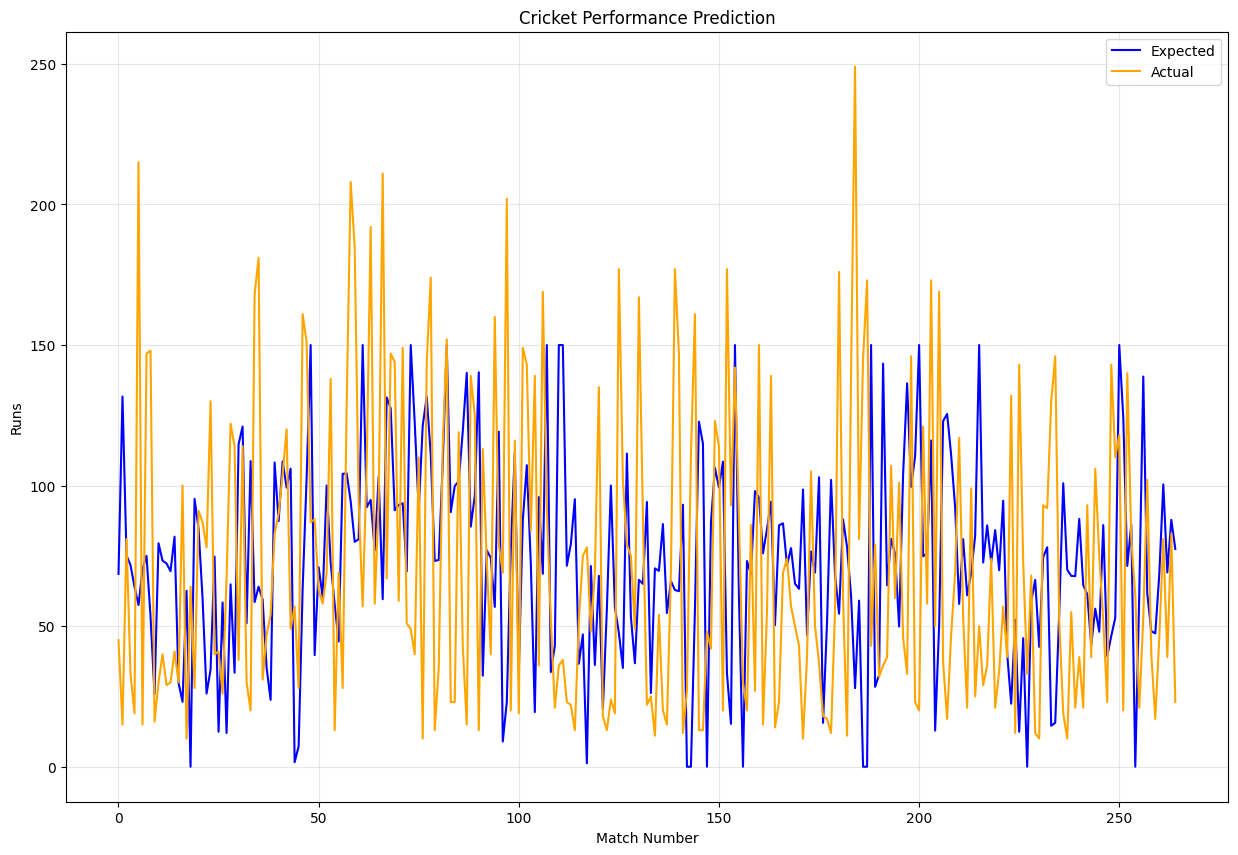

In [ ]:
from statsmodels.tsa.api import VAR
import numpy as np
from sklearn.preprocessing import StandardScaler

def predict_cricket_performance(player_df):
    
    player_df['rolling_avg_3'] = player_df['runs'].rolling(window=1).mean().fillna(method='bfill')
    player_df['runs_diff'] = player_df['runs'].diff().fillna(method='bfill')
    
    columns_to_use = ['runs', 'balls', 'rolling_avg_3', 'runs_diff', 'fours', 'sixes', 'fantasy_points']
    data = player_df[columns_to_use].astype(float)
    
    # Scale the data to prevent numerical issues
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(data)
    
    x1, x2 = [], []
    steps = 1
    window_size = 20  # Fixed window size

    for i in range(window_size, len(scaled_data), steps):
        try:
            # Use a rolling window approach
            window_data = scaled_data[i-window_size:i]
            
            # Fit VAR model with smaller lag
            model = VAR(window_data)
            model_fit = model.fit(maxlags=1)
                        
            # Make forecast and inverse transform
            forecast = model_fit.forecast(window_data, steps=1)
            forecast_original = scaler.inverse_transform(forecast)
            
            actual = data.iloc[i + steps]['fantasy_points'] if i + steps < len(data) else None
            expected = forecast_original[0][-1] if i + steps < len(data) else None
            
            if expected is not None:
                x1.append(min(150,max(0, expected)))  # Ensure non-negative runs and less than 200 
            if actual is not None:
                x2.append(actual)
                
        except Exception as e:
            print(f"Skipping prediction at index {i} due to: {e}")
            continue

    # Plotting
    plt.figure(figsize=(15, 10))
    plt.plot(x1, label='Expected', color='blue')
    plt.plot(x2, label='Actual', color='orange')
    plt.title("Cricket Performance Prediction")
    plt.xlabel("Match Number")
    plt.ylabel("Runs")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    return x1, x2

expected_runs, actual_runs = predict_cricket_performance(player_df)

## Pitch Metrics

In [7]:
date,teams = metadata["date"],metadata["teams"]
all_teams = set()
for i in teams:
    for j in i.split(" vs "):
        all_teams.add(j)
print(all_teams,len(all_teams))

{'Scotland', 'Netherlands', 'United States of America', 'India', 'Thailand', 'England', 'Ireland', 'Africa XI', 'Nepal', 'Bangladesh', 'Sri Lanka', 'Kenya', 'Pakistan', 'Asia XI', 'New Zealand', 'West Indies', 'Bermuda', 'Hong Kong', 'Namibia', 'Oman', 'ICC World XI', 'Zimbabwe', 'Jersey', 'Australia', 'South Africa', 'Canada', 'Papua New Guinea', 'United Arab Emirates'} 28
